# SCDAA Coursework 2022-23
______________________________________________________

**Name & Student Number:**\
Xinyu Zhao s2303292\
Jingzhi Kong s1882018\
Chenxi Hu s1823902

**Online Git Repository:**
https://github.com/Chenxi-Hu93/Coursework-Assignment-2022-23

## Content

- [General Setup](#General-Setup)
- [Part 1: Linear quadratic regulator](#part-1-linear-quadratic-regulator)
    - [Exercise 1.1](#exercise-11)
    - [Exercise 1.2](#exercise-12)
- [Part 2: Supervised learning, checking the NNs are good enough](#part-2-supervised-learning-checking-the-nns-are-good-enough)
    - [Exercise 2.1](#exercise-21)
    - [Exercise 2.2](#exercise-22)
- [Part 3: Deep Galerkin approximation for a linear PDE](#part-3-deep-galerkin-approximation-for-a-linear-pde)
    - [Exercise 3.1](#exercise-31)
- [Part 4: Policy iteration with DGM](#part-4-policy-iteration-with-dgm)
    - [Exercise 4.1](#exercise-41)
- [References](#references)


## General Set-up<a name="General-Setup"></a>

In [1]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Part 1: Linear quadratic regulator<a name="part-1-linear-quadratic-regulator"></a>
We examine the following stochastic differential equation (SDE) for the state process $(X_s)_{s\in[t,T]}$:

\begin{equation}
dX_s = [HX_s + M\alpha_s] ds + \sigma dW_s, \quad s \in [t, T], \quad X_t = x. \tag{1}
\end{equation}

Our objective is to minimize the cost functional $J^\alpha(t, x)$ defined by

\begin{equation}
J^\alpha(t, x) := \mathbb{E}^{t,x}\left[\int^T_t (X^{\top}_s C X_s + \alpha^{\top}D\alpha_s) ds + X^{\top}_T R X_T\right],
\end{equation}

where $C \geq 0$, $R \geq 0$, and $D > 0$ are given deterministic $2 \times 2$ matrices. We seek the value function, denoted by $v(t, x)$:

\begin{equation}
v(t, x) := \inf_{\alpha} J^\alpha(t, x).
\end{equation}

By solving the associated Bellman partial differential equation (PDE), we obtain the expression for the value function:

\begin{equation}
v(t, x) = x^{\top}S(t)x + \int^T_t \operatorname{tr}(\sigma\sigma^{\top}S_r) dr,
\end{equation}

where $S$ is the solution to the Riccati ordinary differential equation (ODE):

\begin{equation}
\begin{aligned}
S'(r) &= -2H^{\top}S(r) + S_r MD^{-1}M^{\top}S(r) - C, \quad r \in [t, T], \\
S(T) &= R.
\end{aligned}
\end{equation}

The solution $S$ takes values in the space of $2 \times 2$ matrices. Consequently, the optimal Markov control is given by

\begin{equation}
a(t, x) = -D^{-1}M^{\top}S(t)x.
\end{equation}


### Exercise 1.1<a name="exercise-11"></a>
To implement this solution, we are asked to write a class that can be initialized with the matrices specifying the LQR problem and $T>0$. The class should have a method that will solve (approximate) the associated Ricatti ODE on a time grid which is an input (numpy array or torch tensor). Additionally, it should have a method that given a torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size $\times 1 \times 2$ (for space), will return a torch tensor of dimension batch size $\times 1$ with entries being the control problem value $v(t, x)$ for each $t$, $x$ in the batch (for $x$ two dimensional). Finally, the class should have another method that, given a torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size $\times 1 \times 2$ (for space), will return a torch tensor of dimension batch size $\times 2$ with entries being the Markov control function for each $t$, $x$ in the batch (for $x$ two dimensional).

In [2]:
class LQR:
    """Linear Quadratic Regulator (LQR) for a linear time-invariant system with state-dependent noise."""

    def __init__(self, H, M, C, D, R, T, N, sigma):
        """Initializes the LQR problem with given system matrices, cost weights, time horizon, and noise standard deviation."""
        self.H = H  # state transition matrix
        self.M = M  # control matrix
        self.C = C  # state cost matrix
        self.D = D  # control cost matrix
        self.R = R  # final state cost matrix
        self.T = T  # time horizon
        self.sigma = sigma # state-dependent noise standard deviation
        self.N = N  # number of time step
       
        
    def solve_riccati(self, time_grid):
        """Solves the Riccati ode. """
        time_grid = torch.flip(time_grid, dims=[0])
        def riccati(S,t,H,M,D,C):
            S =  torch.tensor(S)
            S = torch.reshape(S,(2, 2))
            dSdt = -2 * H.T @ S + S @ M @ torch.inverse(D) @ M.T @ S - C
            return dSdt.flatten()
    
        # Terminal condition S(T)=R is the initial condition here
        S0=self.R
        
        # Slove ode
        S = odeint(riccati,S0.flatten(),time_grid,args=(self.H, self.M,self.D,self.C))
        
        S = torch.reshape(torch.tensor(S),(len(time_grid), 2, 2))
        S_reversed = torch.flip(S, dims=[0])

        return S_reversed.to(dtype=torch.float64)
        
    def value(self,time,space):
        """input: one torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size × 1 × 2 (for space)
           return: a torch tensor of dimension batch size × 1 with entries being the control problem value v(t, x) for each t, x in the batch"""
        batch_size=time.size(0)
        end_time = torch.ones(batch_size) * self.T
        time_grid = torch.linspace(0, 1, self.N).unsqueeze(0).repeat(batch_size, 1)
        time_grid = time.view(-1, 1) + (end_time - time).view(-1, 1) * time_grid
        S_batch = torch.empty((batch_size, self.N, 2, 2),dtype=torch.float64)
        for i in range(batch_size):
            S_batch[i] = self.solve_riccati(time_grid[i])
        
        product = self.sigma @ torch.transpose(self.sigma, 0, 1)  @ S_batch
        temp = torch.diagonal(product, dim1=-2, dim2=-1).sum(dim=2)
        temp1 = space @ S_batch[:, 0, :, :] @ torch.transpose(space,1,2)
        v1=torch.reshape(temp1, (batch_size, 1))
        v2=torch.reshape(torch.trapz(temp, time_grid), (batch_size, 1))#[:, 0:1]
        v = v1+v2
        return v 
    
    def control(self, time, space):
        """input: one torch tensor of dimension batch size (for time) and another torch tensor of dimension batch size × 1 × 2 (for space)
           return: a torch tensor of dimension batch size × 2 with entries being the Markov control function for each t, x in the batch """
        batch_size = time.size(0)
        end_time = torch.ones(batch_size) * self.T
        time_grid = torch.linspace(0, 1, self.N).unsqueeze(0).repeat(batch_size, 1)
        time_grid = time.view(-1, 1) + (end_time - time).view(-1, 1) * time_grid
        S_batch = torch.empty((batch_size, self.N, 2, 2)).double()
        for i in range(batch_size):
            S_batch[i] = self.solve_riccati(time_grid[i])
        a = -torch.inverse(self.D.float()) @ self.M.T.float() @ S_batch[:, 0, :, :].float() @ torch.transpose(space, 1, 2).float()
        a = torch.reshape(a, (batch_size, 2))
        return a

In [3]:
H = torch.tensor([[1,0],[0,1]], dtype=torch.float64)
M = torch.tensor([[1,0],[0,1]], dtype=torch.float64)
sigma = torch.tensor([[0.05],[0.05]], dtype=torch.float64)
C = torch.tensor([[0.1,0],[0,0.1]], dtype=torch.float64)
D = torch.tensor([[0.1,0],[0,0.1]], dtype=torch.float64)
R = torch.tensor([[1,0],[0,1]], dtype=torch.float64)
T = 1
#time_grid=torch.linspace(0, T, 6)
if __name__ == '__main__': 
    result = LQR(H, M, C, D, R, T, 100,sigma) 
    time = torch.rand(5, dtype=torch.float64)*T
    space = torch.rand(5, 1, 2, dtype=torch.float64)
    result.value(time,space)
    result.control(time,space)
   


**Object:**
The program presents a LQR class that can solve the Linear Quadratic Regulator problem for a linear time-invariant system with state-dependent noise. The LQR class incorporates various methods, such as solving the Riccati ODE, calculating the value and control for a given time and space, and computing the control sequence for a given time and space. The LQR class receives input parameters that describe the LQR problem in optimal control, such as H, the state transition matrix, M, the control matrix, C, the state cost matrix, D, the control cost matrix, R, the final state cost matrix, T, the terminal time, sigma, the standard deviation of state-dependent noise, and N, the number of time steps required to calculate the value and control for a given time and space.

**Methodology:**

- The `solve_riccati` method uses the odeint function from the PyTorch library to solve the Riccati ODE. The Riccati ordinary differential equation (ODE) includes a final condition where S(T) is equal to R. To address this issue, we employ a time grid that ranges from T to t, so that the final condition becomes the initial condition. This approach facilitates the use of the 'odeint' function to solve the problem easily. By reversing the output of 'odeint', we can obtain the solution to the Riccati ODE. It is important to note that the code already includes the inversion of time and solution, so the input should be a time grid in the normal order from t to T to obtain a solution to the Riccati ODE with respect to this time grid.

- The `value` method computes the optimal value for the linear quadratic regulator problem using the analytical formula. Given input tensors of corresponding initial times t and initial states x, this method generates time grids from each t to T with N time steps, where T and N are parameters of the class. The matrix S, which is part of the analytical solution for the optimal value, is obtained by solving the Riccati ODE using the solve_riccati method and the time grid. The method then computes the product of the state-dependent noise standard deviation, its transpose, and the solution of the Riccati ODE S for each input (t,x). The diagonal elements of this product are extracted and summed over all inputs (t,x). The optimal value function for each input initial time t is then calculated by taking the dot product of the input initial state x, S at time t, and the transpose of the input initial state. Finally, the integral of the summed diagonal elements of the product over the time horizon is computed using the trapezoidal rule. The result is reshaped to a tensor of size (batch_size, 1) and added to the previously computed value to obtain the optimal value function for each input initial time t and input initial state x. The output of this method is a tensor of size (batch_size, 1).

- The `control` method bases on the analytical formula to compute the optimal control for the linear quadratic regulator problem. It takes input tensors of initial times t and initial states x and computes the product of the inverse of the control cost matrix D, the transpose of the control matrix M, the solution of the Riccati ODE at the initial time t, and the transpose of the initial state x. The resulting tensor has a size of (batch_size, 2).

**Conclusion:** 
The LQR class presented in this work is a practical and effective tool for solving the Linear Quadratic Regulator problem in a linear time-invariant system with state-dependent noise. The class integrates various methods such as solving the Riccati ODE, computing the optimal value and control for specific initial times and states, and takes input parameters including H, M, C, D, R, T, sigma, and N. The solve_riccati method utilizes the odeint function to solve the Riccati ODE, while the value and control methods use the analytical formula to calculate the optimal value and control for each input initial time t and input initial state x. The resulting tensors have sizes of (batch_size, 1) and (batch_size, 2), respectively. In summary, the LQR class offers an effective and convenient solution for the Linear Quadratic Regulator problem with state-dependent noise.

### Exercise 1.2<a name="exercise-12"></a>
In Exercise 1.2, our objective is to evaluate the accuracy of Monte Carlo simulation of the system using the optimal control obtained from Exercise 1.1, and ensure that it converges to the optimal value function. To accomplish this, we compare the error between the simulated value and the true optimal value obtained by the `value` function in the class `LQR`. The error is measured by Mean Squared Error (MSE). This is a good choice because it is a widely used metric and it is sensitive to small differences.

We will vary the number of time steps and the number of Monte Carlo samples to investigate their effect on the error. For the first experiment, we will fix the number of Monte Carlo samples to $10^5$ and vary the number of time steps. Specifically, we will take 1, 10, 50, 100, 500, 1000, and 5000 time steps. We will then plot the error on a log-log scale.For the second experiment, we will fix the number of time steps to 5000 and vary the number of Monte Carlo samples. Specifically, we will take 10, 50, $10^2$, $5\times10^2$, $10^3$, $5\times10^3$, $10^4$, $5\times10^4$, and $10^5$ Monte Carlo samples. We will then plot the error on a log-log scale.

We will use explicit scheme to do a time discretization.

In [4]:
def mse(x, y):
    return torch.mean((x - y)**2)

In [5]:
# Vary number of time steps
num_samples =100000
num_steps = [1, 10, 50, 100, 500,1000,5000]

batch_size = 50
x =  torch.rand(batch_size,1, 2,dtype=torch.float64)
t=  torch.rand(batch_size,dtype=torch.float64)
T=1

errors = [] 
v_true = result.value(t,x)
v_true = torch.reshape(v_true,(1,-1))
for N in num_steps:
    end_time = torch.ones(batch_size, dtype=torch.float64) * T
    time_grid = torch.linspace(0, 1, N+1).unsqueeze(0).repeat(batch_size, 1)
    time_grid = t.view(-1, 1) + (end_time - t).view(-1, 1) * time_grid
    S_batch = torch.empty((batch_size, N+1, 2, 2),dtype=torch.float64)
    for i in range(batch_size):
        S_batch[i] = result.solve_riccati(time_grid[i])
    X =torch.reshape(x.repeat(num_samples, 1, 1),(num_samples,batch_size ,2, 1))#num_samples,batch_size,num_steps+1,2,1
    tau=(T-t)/N
    v_temp = 0
    X_new = 0
    for n in range(0, N):
        a  = -torch.inverse(D) @ M.T @ S_batch[:,n,:,:] @ X
        X_new =  X + (H @ X + M @ a )*(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)) + torch.reshape(torch.transpose(sigma*torch.reshape(torch.randn(num_samples,batch_size) *  torch.sqrt(tau),(1,num_samples*batch_size)),0,1),(num_samples,batch_size,2,1))
        v_temp +=( torch.transpose(X,2,3)@ (C @X)+torch.transpose(a,2,3) @ (D @ a)) *(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1))
        X = X_new
    v_temp += torch.transpose(X,2,3)@ (R @X)
    MC_results = torch.mean(v_temp, dim=0)
    errors.append(mse(torch.reshape(MC_results,(1,batch_size)), v_true))

Text(0, 0.5, 'Error')

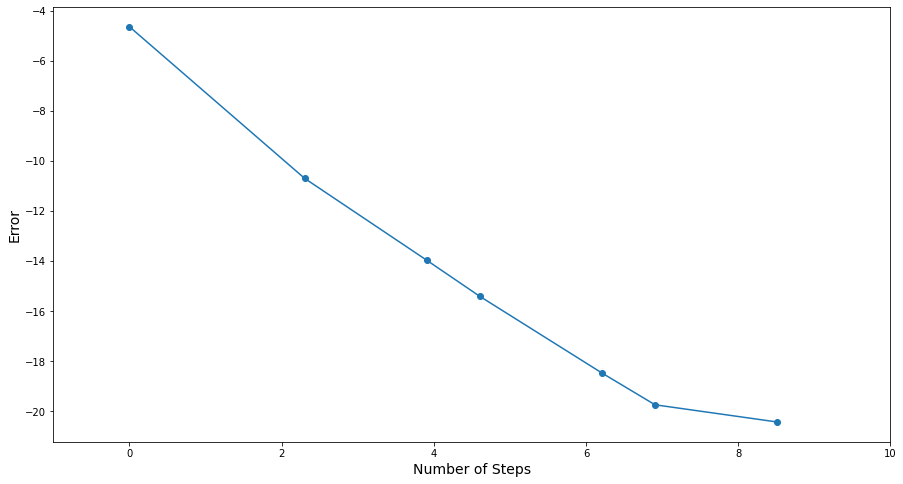

In [6]:
log_num_steps = np.log(num_steps)
plt.figure(figsize=(15, 8))
log_errors = np.log(errors)
plt.plot(log_num_steps, log_errors, marker='o',linestyle='-')
plt.xlim([-1, 10])
plt.xlabel('Number of Steps', fontsize=14)
plt.ylabel('Error', fontsize=14)

**Objective:**\
The aim of this code is to employ the Monte Carlo method to solve a stochastic control problem for a linear quadratic regulator (LQR) with a time-varying state equation and additive Gaussian noise. Additionally, the code examines the impact of the time step on the error between the true values of the optimal value and the values obtained by the Monte Carlo method, with respect to various randomly generated initial times and spaces.

**Methodology:**\
The code uses the following steps to do the Monto Carlo simulation:
- Define a mean-square error function to calculate the error between the true values of the optimal value and the values obtained by the Monte Carlo method corresponding to several randomly generated initial time and space. The outputs of the function `value` in the class `LQR` are seen as the true value, which is the analytical solution of the LQR optimal control problem.
- Define the number of samples, number of time steps, and batch size of random inputs to use in the simulation.
- Generate the time grid for the simulation for each input in the batch and solve the Riccati differential equation using the `solve_riccati` method of class `LQR`.
- Initialize the state variable `X` as a tensor of size num_samples x batch_size x 2 x 1.
- Calculate the state variable `X` for the next time step using the current state X and the Riccati solution `S_batch[:,n,:,:]` along with a Gaussian noise term. To save memory, only tensor `X` and tensor `X_new` are saved in each time step where `X` represents the current state of the system for each sample in the batch, while the tensor `X_new` represents the state of the system at next time step. 
- Calculate the integral term in the objective function. The Riemann integral definition is used to approximate the integral, and once the integral is calculated, the used `X` is discarded, and `X = X_new` is set to maintain the algorithm's efficiency.
- Calculate the final cost using the updated state variable `X` and the terminal cost matrix R.
- Calculate the Monte Carlo estimate of the optimal value function by averaging the costs over all samples.
- Calculate the mean-squared error between the Monte Carlo estimate and the true value function for the given inputs.
- Plot the error as a function of the number of time steps used in the simulation.

**Results:**\
From the above figure we can see that the error decreases as the number of time steps increases, indicating that the Monte Carlo method is converging towards the true value of the optimal control problem, which illustrates that the fine division in time greatly improves the preparation of simulation.


In [7]:
# Vary number of samples
num_samples_list =[10, 50,100,5*10**2,10**3, 5*10**3, 10**4, 5*10**4, 10**5]
N =5000
batch_size = 50
x =  torch.rand(batch_size,1, 2,dtype=torch.float64)
t=  torch.rand(batch_size,dtype=torch.float64)
errors = [] 
v_true = result.value(t,x)
v_true = torch.reshape(v_true,(1,-1))
for num_samples in num_samples_list:
    end_time = torch.ones(batch_size, dtype=torch.float64) * T
    time_grid = torch.linspace(0, 1, N+1).unsqueeze(0).repeat(batch_size, 1)
    time_grid = t.view(-1, 1) + (end_time - t).view(-1, 1) * time_grid
    S_batch = torch.empty((batch_size, N+1, 2, 2),dtype=torch.float64)
    for i in range(batch_size):
        S_batch[i] = result.solve_riccati(time_grid[i])
    X =torch.reshape(x.repeat(num_samples, 1, 1),(num_samples,batch_size ,2, 1))#num_samples,batch_size,num_steps+1,2,1
    tau=(T-t)/N
    v_temp = 0
    X_new = 0
    for n in range(0, N):
        a  = -torch.inverse(D) @ M.T @ S_batch[:,n,:,:] @ X
        X_new =  X + (H @ X + M @ a )*(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1))+ torch.reshape(torch.transpose(sigma*torch.reshape(torch.randn(num_samples,batch_size)*  torch.sqrt(tau),(1,num_samples*batch_size)),0,1),(num_samples,batch_size,2,1))
        v_temp += ( torch.transpose(X,2,3)@ (C @X)+torch.transpose(a,2,3) @ (D @ a)) *(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1))
        X = X_new
    v_temp += torch.transpose(X,2,3)@ (R @X)
    MC_results = torch.mean(v_temp, dim=0)
    errors.append(mse(torch.reshape(MC_results,(1,batch_size)), v_true))

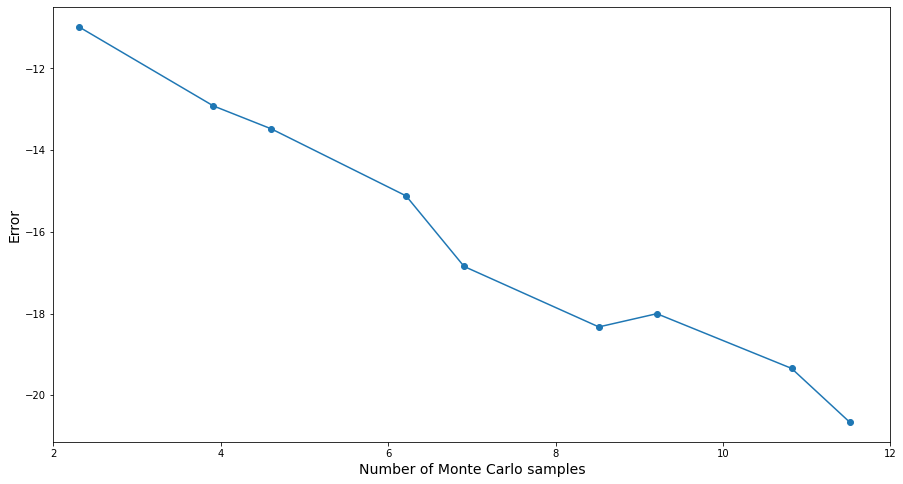

In [8]:
log_num_samples_list = np.log(num_samples_list)
log_errors = np.log(errors)
plt.figure(figsize=(15, 8))
plt.plot(log_num_samples_list, log_errors, marker='o',linestyle='-')
plt.xlim([2, 12])
plt.xlabel('Number of Monte Carlo samples', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.show()

**Objective:** \
The aim of this program is to use the Monte Carlo method to solve a stochastic control problem for a linear quadratic regulator (LQR) with a time-varying state equation and additive Gaussian noise, while also studying the impact of the number of samples on the accuracy of the results obtained. The program generates random initial times and spaces and evaluates the error between the true values of the optimal value and the values obtained using the Monte Carlo method.

**Methodology:** \
The methodology employed is similar to the previous program, with the exception that the number of samples varies in this case.

**Results:** \
With the increase in log of sample size, log of error will have a downward trend close to linear. Additionally, compared with above fugure, we could find that when the timestep is large enough, even though the sample is small, the error is still small. Thus, it is observed that fine time division is more important in improving the accuracy of the simulation than a large number of samples, as compared to the previous experiment.

## Part 2: Supervised learning, checking the NNs are good enough<a name="part-2-supervised-learning-checking-the-nns-are-good-enough"></a>

In part 2, a neural network is defined as a parametric function that depends on an input, denoted as $x \in \mathbb{R}^d$, and parameters, denoted as $\theta \in \mathbb{R}^p$, taking values in $\mathbb{R}^{d'}$. We write this function as:

\begin{equation}
\phi = \phi(x; \theta).
\end{equation}

An example of a one-hidden-layer neural network is given by

\begin{equation}
\phi(x; \theta) = \phi(x; \alpha^{(1)}, \alpha^{(2)}, \beta^{(1)}, \beta^{(2)}) = \alpha^{(1)}\psi(\alpha^{(2)}x + \beta^{(2)}) + \beta^{(1)},
\end{equation}

where $\psi$ is an activation function applied component-wise, $\alpha^{(2)}$ is an $h \times d$ matrix, $\beta^{(2)}$ is an $h$-dimensional vector, $\alpha^{(1)}$ is a $d' \times h$ matrix, and $\beta^{(1)}$ is a $d'$-dimensional vector. In this case, $\theta = (\alpha^{(1)}, \alpha^{(2)}, \beta^{(1)}, \beta^{(2)})$, and $p = h \times d + h + d' \times h + d'$ represents the number of parameters or "weights" depending on the size of the hidden layer $h$.

The most relevant supervised learning task for our purposes is as follows: We aim to find neural network (NN) weights $\theta^*$ such that our NN $\phi(\cdot; \theta^*)$ is a good approximation of some function $f$. We are given a training dataset $\{(x^{(i)}, f(x^{(i)}))\}^{N_{\text{data}}}_{i=1}$ and search for $\theta^*$ by attempting to minimize

\begin{equation}
R(\theta) := \frac{1}{N_{\text{data}}} \sum^{N_{\text{data}}}_{i=1} \left|\phi(x^{(i)}; \theta) - f(x^{(i)})\right|^2
\end{equation}

over $\theta \in \mathbb{R}^p$ by running some variant of a gradient descent algorithm. For example, starting with an initial guess of $\theta^{(0)}$, we update $\theta^{(k+1)}$ as

\begin{equation}
\theta^{(k+1)} = \theta^{(k)} - \gamma \nabla_\theta R(\theta^{(k)}), \quad k = 0, 1, 2, \dots.
\end{equation}


### Exercise 2.1<a name="exercise-21"></a>
In this section of the report, we will discuss the question related to supervised learning of value function $v$ using a neural network with a hidden layer size of 100. The goal is to find the neural network weights that provide a good approximation of the value function. The neural network is a parametric function that depends on an input $x$, parameters $\theta$, and takes values in $\mathbb{R}^{d'}$. We will write $\phi = \phi(x; \theta)$ to denote the neural network function.

An example of a one hidden layer neural network is given by $\phi(x; \theta) = \phi(x; \alpha^{(1)}, \alpha^{(2)}, \beta^{(1)}, \beta^{(2)}) = \alpha^{(1)}\psi(\alpha^{(2)}x + \beta^{(2)}) + \beta^{(1)}$, where $\psi$ is an activation function that is applied component-wise, $\alpha^{(2)}$ is a $h \times d$ matrix, $\beta^{(2)}$ is an $h$-dimensional vector, $\alpha^{(1)}$ is a $d' \times n$ matrix, and $\beta^{(1)}$ is a $d'$-dimensional vector. The number of parameters or weights of the neural network is given by $p = h \times d + h + d' \times h + d'$, depending on the size of the hidden layer $h$.

To train the neural network, we need a training dataset $\{(x^{(i)}, f(x^{(i)}))\}^{N_{\text{data}}}_{i=1}$ , where $N_{data}$ is the number of training samples, and $f$ is the function we want to approximate. We search for the optimal weights $\theta^*$ by minimizing the mean squared error loss function $R(\theta) = \frac{1}{N_{data}}\sum_{i=1}^{N_{data}} |\phi(x^{(i)}; \theta) - f(x^{(i)})|^2$ over $\theta \in \mathbb{R}^p$ using a gradient descent algorithm.

Exercise 2.1 asks us to use the neural network with a hidden layer size of 100 and generate training data $v(t^{(i)}, x^{(i)})$ by sampling $t$ uniformly on $[0, T]$ and $x$ uniformly on $[-3, 3] \times [3, 3]$ for $T = 1$. We will use the torch Adam optimizer to find the network weights that provide a good approximation of the value function. Finally, we need to provide a plot of the training loss to evaluate the performance of the neural network.

In [6]:
# Provided DGM_Layer and Net_DGM classes
#from lib.options import BaseOption

class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output


class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output



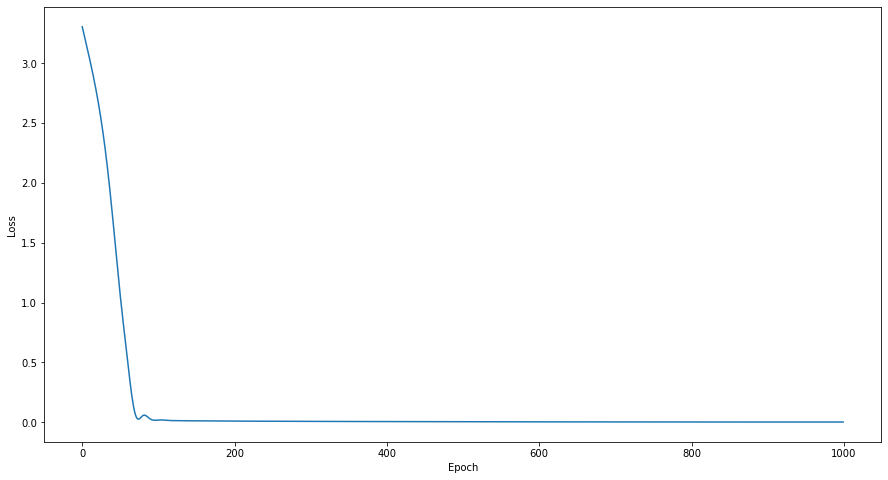

In [10]:
# Generate training data
N_data = 2000
t_train = (torch.rand(N_data) * T).double()
x_train = (torch.rand(N_data, 2) * 6 - 3).double()
v_train = (result.value(t_train, x_train.unsqueeze(1))).double()

# Create neural network
dim_x = 2
dim_S = 100
net = Net_DGM(dim_x, dim_S).double()

# Set up the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (800,),gamma=0.1)
loss_fn = nn.MSELoss()

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(t_train.unsqueeze(1), x_train)
    loss = loss_fn(outputs, v_train)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

# Plot the training loss
plt.figure(figsize=(15, 8))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**Objective:**
The optimal control problem is a common challenge in engineering and scientific applications. Solving the optimal control problem involves finding the control inputs that optimize a given performance criterion. In the Exercise 1, we generete optimal value and optimal control accoring to analytic solutions. However, analytical solutions are not always feasible, and approximations may be required. Deep Generative Models (DGMs) have emerged as a promising method to approximate optimal controls. In this part, we aim to built a DGM neural network by using the provided Net_DGM class to approximate the optimal value of LQR and present our methodology and results.

**Methodology:**
- Generate training data: We generated 2000 training data points (t_train, x_train) by sampling t and x uniformly distributed on [0,T] and [-3, 3] x [3, 3], respectively. We then generated v_train by using the value function in the LQR class defined in Exercise 1.1.
- Create the neural network: We created a neural network using the provided Net_DGM class with dimensions dim_x = 2 and dim_S = 100, as the combined dimension of t and x is 3, and the hidden layer size is 100.
- Set up the optimizer: We set up the Adam optimizer with a learning rate of 0.0001 and a scheduler to adjust the learning rate after 800 epochs with a gamma of 0.1. Thus, the learning rate of the Adam optimizer was timed by 0.1 after 800 epochs.
- Define the loss function: We defined the loss function as the Mean Squared Error (MSE) loss.
- Train the neural network: We trained the neural network for 1000 epochs, updating the weights through backpropagation.
- Plot the training loss: We plotted the training loss over the epochs.

**Results:**\
The training loss plot shows that the loss gradully converges to 0, indicating that the neural network has learned to approximate the value function v well. This is a positive result, as it means that the network has effectively captured the underlying pattern in the data and can now provide good approximations for the value function.

**Conclusion:**\
In conclusion, Exercise 2.1 demonstrates the effectiveness of using DGM neural network with hidden layer of size 100 in approximating the value function. The network was able to learn from the training data and minimize the loss, resulting in accurate approximations. 

### Exercise 2.2<a name="exercise-22"></a>

Exercise 2.2 involves applying supervised learning to the Markov control problem discussed in Exercise 1.1. The goal is to use a neural network with 2 hidden layers of size 100 to approximate the Markov control function. Unlike in Exercise 2.1, the output of the neural network must be 2-dimensional, as the Markov control function returns a 2-dimensional vector. To accomplish this, we will use the [1, FFN class] neural network architecture. Similar to Exercise 2.1, we will use a training dataset consisting of pairs $(t^{(i)}, x^{(i)}, a^{(i)})$ for $i = 1, ..., N_{data}$, where $N_{data}$ is the number of training samples, $t$ is uniformly sampled from $[0, T]$, $x$ is uniformly sampled from $[-3, 3] \times [-3, 3]$, and $a$ is the Markov control function. We will minimize the mean squared error loss function using the torch Adam optimizer to find the optimal weights of the neural network. Finally, we will evaluate the performance of the neural network by providing a plot of the training loss.

In [5]:
# Provided FFN class
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]).double())
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True).double())
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)

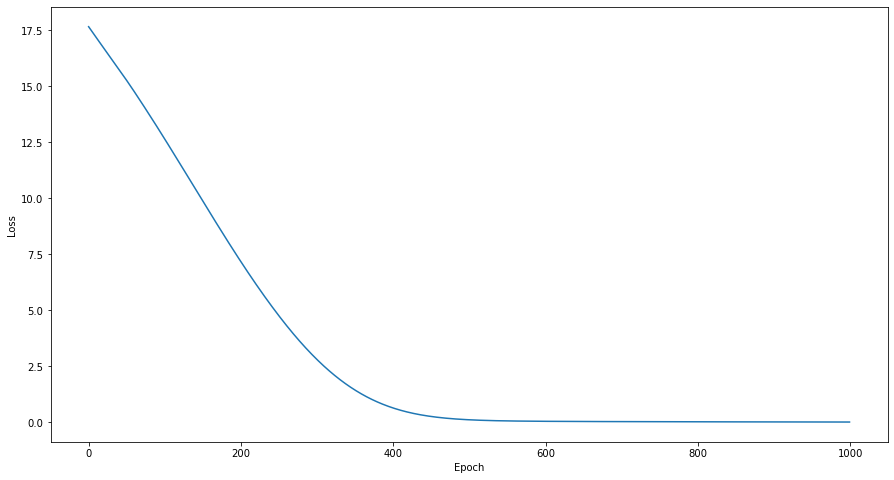

In [12]:
# ... (FFN class and LQR instantiation code remain unchanged) ...
lqr = LQR(H, M, C, D, R, T, 100, sigma)

# Problem parameters
T = 1
num_epochs = 1000

# Generate training data
N_data = 2000
t_data = np.random.uniform(0, T, size=(N_data, 1)).astype(np.float64)
x_data = np.random.uniform(-3, 3, size=(N_data, 2)).astype(np.float64)
a_data = np.array([lqr.control(torch.tensor(t, dtype=torch.float64), torch.tensor(x, dtype=torch.float64).view(1, 1, 2)).detach().numpy() for t, x in zip(t_data, x_data)])

# Create neural network
sizes = [3, 100, 100, 2]  # input_dim=3 (t, x1, x2), output_dim=2
net = FFN(sizes, activation=nn.ReLU, output_activation=nn.Identity)

# Set up the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Define the MSE loss
mse_loss = nn.MSELoss()

# Training loop
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Use the entire dataset
    t_batch = torch.tensor(t_data, dtype=torch.float64)
    x_batch = torch.tensor(x_data, dtype=torch.float64)
    a_batch = torch.tensor(a_data, dtype=torch.float64)

    # Forward pass
    tx_batch = torch.cat((t_batch, x_batch), dim=1)
    a_pred = net(tx_batch)
    #Add dimension to a_pred
    a_pred = a_pred.unsqueeze(dim=1)

    # Calculate loss using MSE
    loss = mse_loss(a_pred, a_batch)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


# Plot the training loss
plt.figure(figsize=(15, 8))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

**Objective:**\
The goal of Exercise 2.2 is to train a neural network to approximate the Markov control from Exercise 1.1. We use the provided Feed-Forward Neural Network (FFN) class with two hidden layers of size 100.

**Methodology:**
- Generate training data: We generated 2000 training data points (t_train, x_train) by sampling t and x uniformly distributed on [0,T] and [-3, 3] x [3, 3], respectively. We then generated corresponding optimal control action a by using the control function in the LQR class defined in Exercise 1.1.
- Create the neural network: We created a neural network using the provided FNN class with dimensions size = [3, 100, 100, 2], which means that there are one input layer with 3 neurons, two hidden layers both with 100 neurons and one output layer with two neurons corresponding to the dimension of the optimal control action.
- Set up the optimizer: We set up the Adam optimizer with a learning rate of 0.0001.
- Define the loss function: We defined the loss function as the Mean Squared Error (MSE) loss.
- Train the neural network: We trained the neural network for 1000 epochs, updating the weights through backpropagation.
- Plot the training loss: We plotted the training loss over the epochs to visualize the learning process of the neural network.

**Results:**\
The training loss plot demonstrated that the loss gradually converges to 0 as the number of epochs increases. This result indicates that the neural network was able to learn from the training data and provide good approximations of the the optimal control actions.

**Conclusion:**\
In conclusion, the neural network trained in Exercise 2.2 is capable of approximating the Markov control from Exercise 1.1. The choice of dimensions, optimizer setup, loss function, and training process were appropriate, leading to the effective learning of the neural network. The training loss plot provided a visual representation of the neural network's learning process, demonstrating its effectiveness in approximating the optimal control action of LQR.

## Part 3: Deep Galerkin approximation for a linear PDE<a name="part-3-deep-galerkin-approximation-for-a-linear-pde"></a>

Consider the linear partial differential equation (PDE) with $\alpha = (1, 1)^\top$ and $H, M, C, D, R, \sigma$ as the matrices from Exercise (1.1):

\begin{equation}
\begin{aligned}
&\partial_t u + \frac{1}{2} \operatorname{tr}(\sigma\sigma^{\top}\partial_{xx}u) +(\partial_x u)^{\top}Hx + (\partial_x u)^{\top}M\alpha + x^{\top}Cx + \alpha^{\top}D\alpha = 0 &\text{ on } [0, T) \times \mathbb{R}^2, \\
&u(T, x) = x^{\top}Rx &\text{ on } \mathbb{R}^2.
\end{aligned}
\end{equation}

This PDE represents the linearization of the Bellman PDE resulting from taking the constant control $\alpha = (1, 1)^\top$, regardless of the state of the system. The deep Galerkin method replaces $u$ with a neural network approximation $u(\cdot, \cdot; \theta)$, selects random points from the problem domain $(t^{(i)}, x^{(i)})$ with $i = 1, \dots, N_{\text{batch}}$, and aims to minimize

\begin{equation}
R(\theta) := R_{\text{eqn}}(\theta) + R_{\text{boundary}}(\theta),
\end{equation}

where

\begin{equation}
\begin{aligned}
R_{\text{eqn}}(\theta) &= \frac{1}{N_{\text{batch}}} \sum^{N_{\text{batch}}}_{i=1} \left|\partial_t u(t^{(i)}, x^{(i)}; \theta) + \frac{1}{2}\operatorname{tr}(\sigma\sigma^{\top}\partial_{xx}u(t^{(i)}, x^{(i)}; \theta)) + (\partial_x u(t^{(i)}, x^{(i)}; \theta))^{\top} Hx^{(i)} \right. \\
&\qquad \left. + (\partial_x u(t^{(i)}, x^{(i)}; \theta))^{\top} M\alpha + (x^{(i)})^{\top}Cx^{(i)} + \alpha^{\top}D\alpha\right|^2, \\
R_{\text{boundary}}(\theta) &= \frac{1}{N_{\text{batch}}} \sum^{N_{\text{batch}}}_{i=1} \left|u(T, x^{(i)}; \theta) - (x^{(i)})^{\top}Rx^{(i)}\right|^2,
\end{aligned}
\end{equation}

over $\theta \in \mathbb{R}^p$. Since the right-hand side of the PDE we are solving is zero, if we can achieve $R(\theta) = 0$, we have a good approximation of the solution.


### Exercise 3.1<a name="exercise-31"></a>

In this exercise, we implement the Deep Galerkin method for the given linear PDE. Our goal is to train a DGM network to aprroximate the solution of this pde and provide a plot of the training loss and the error against the Monte Carlo solution at reasonable intervals. We will adapt the Monte Carlo solution from Exercise 1.2 by replacing the optimal control with the constant $\alpha$. 

In [13]:
def MC_results(x, t, num_samples, num_steps, T):
    batch_size = t.size(0)
    end_time = torch.ones(batch_size, dtype=torch.float64) * T
    time_grid = torch.linspace(0, 1, num_steps+1).unsqueeze(0).repeat(batch_size, 1)
    time_grid = t.view(-1, 1) + (end_time - t).view(-1, 1) * time_grid
    S_batch = torch.empty((batch_size, num_steps+1, 2, 2),dtype=torch.float64)
    for i in range(batch_size):
        S_batch[i] = result.solve_riccati(time_grid[i])
    X =torch.reshape(x.repeat(num_samples, 1, 1),(num_samples,batch_size ,2, 1))#num_samples,batch_size,num_steps+1,2,1
    tau=(T-t)/num_steps
    v_temp = 0
    X_new = 0
    for n in range(0, num_steps):
        a  = torch.tensor([[1],[1]],dtype=torch.float64).repeat(num_samples,batch_size,1,1)
        X_new =  X + (H @ X + M @ a )*(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1))+ torch.reshape(torch.transpose(sigma*torch.reshape(torch.randn(num_samples,batch_size)*  torch.sqrt(tau),(1,num_samples*batch_size)),0,1),(num_samples,batch_size,2,1))
        v_temp += ( torch.transpose(X,2,3)@ (C @X)+torch.transpose(a,2,3) @ (D @ a)) *(tau.unsqueeze(0).unsqueeze(-1).unsqueeze(-1))
        X = X_new
    v_temp += torch.transpose(X,2,3)@ (R @X)
    MC_results = torch.reshape(torch.mean(v_temp,dim=0),(1,batch_size))

    return MC_results


The code defines a function named `MC_results`, which utilizes a Monte Carlo method to approximate the solution of a linear pde. The function is similar to the Monte Carlo portion of Exercise 1.2, except that the optimal control action is fixed at (1,1).

The function takes several input arguments:

- `x` is a tensor of size (batch_size,2, 1), representing the states of the system.
- `t` is a tensor of size (batch_size, 1), representing the times of the system.
- `num_samples` is an integer specifying the number of samples used in the Monte Carlo simulation.
- `num_steps` is an integer specifying the number of time steps to use in the simulation. 
- `T` is a scalar representing the final time of the system.

The function initializes `X` with the input `x`. In each loop of the Monte Carlo simulation, the function generates a tensor `X` and a tensor `X_new` with the same size `(num_samples, batch_size, 2, 1)`. `X` represents the current state of the system for each sample in the batch, while the tensor `X_new` represents the state of the system at next time step. To save memory, only these two tensors are saved in each time step. The Riemann integral definition is used to approximate the integral, and once the integral is calculated, the used `X` is discarded, and `X = X_new` is set to maintain the algorithm's efficiency.

After running the Monte Carlo simulation for each input pair of t and x, the function computes the mean of the cost function over all samples to obtain the overall Monte Carlo estimate of the value function. 

Overall, the function implements a Monte Carlo method to approximate the solution of a dynamic optimization problem for a given set of initial stats and time, using a specified number of samples and time steps. 

In [7]:
def get_gradient(output, x):
    grad = torch.autograd.grad(output, x, grad_outputs=torch.ones_like(output), create_graph=True, retain_graph=True, only_inputs=True)[0]
    return grad

def get_hess(grad, x):
    hess = torch.empty((x.shape[0],2,2))
    for d in range(x.shape[1]):
        v = grad[:,d].view(-1,1)
        grad2 = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v), only_inputs=True, create_graph=True, retain_graph=True)[0]
        hess[:,d,:] = grad2
    
    return hess

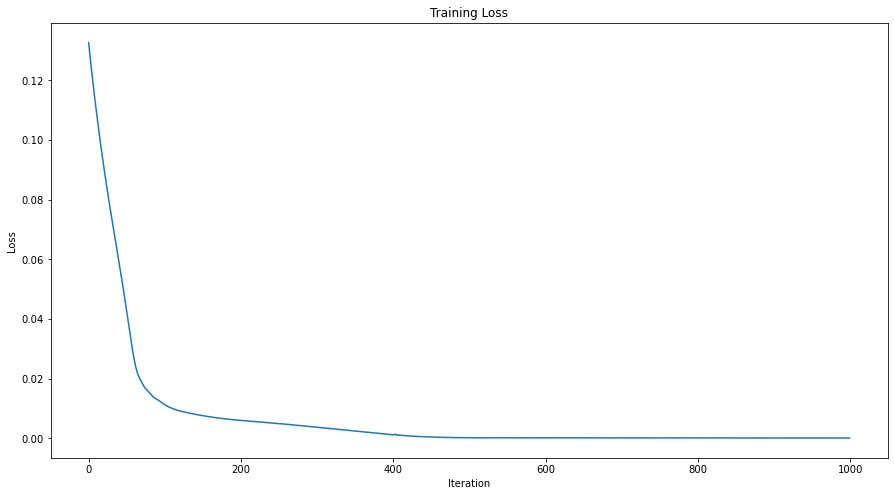

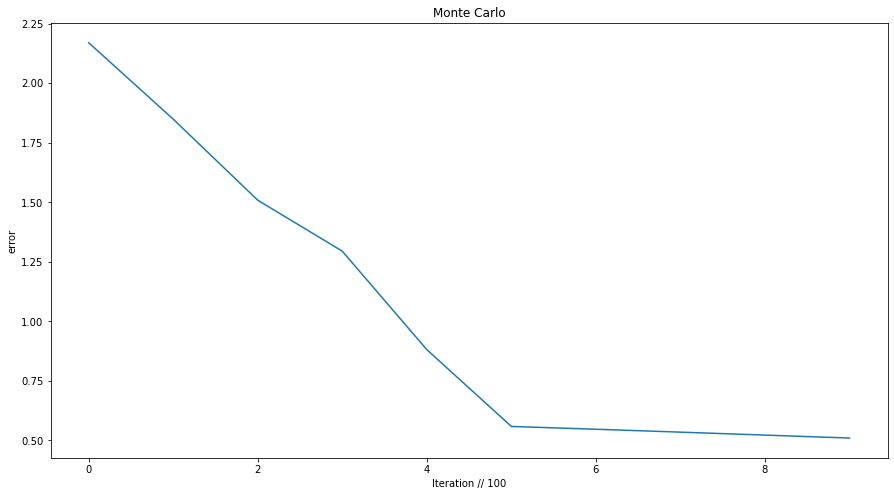

In [15]:
# Neural network
dim_x = 2
dim_S = 100
net_3 = Net_DGM(dim_x, dim_S).double()
T = 1
batch_size = 300
t_3_batch  = (torch.rand(batch_size, requires_grad=True) * T).double()
x_3_batch= (torch.rand(batch_size,2, requires_grad=True) * 2 - 1).double()
MC = MC_results(x_3_batch.detach(), t_3_batch.detach(), 100, 100, T)
optimizer = torch.optim.Adam(net_3.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = (500,),gamma=0.1)

loss_fn = nn.MSELoss()

alpha = torch.tensor([[1.0], [1.0]], dtype=torch.float64)#.clone().detach()
max_updates = 1000
losses = []
error_history = []
for it in range(max_updates):
    optimizer.zero_grad()
    
    u_of_tx = net_3(t_3_batch.unsqueeze(1), x_3_batch)
    grad_u_x = get_gradient(u_of_tx,x_3_batch)
    grad_u_t = get_gradient(u_of_tx,t_3_batch)
    grad_u_xx = get_hess(grad_u_x, x_3_batch)
    
    trace = torch.matmul(sigma.view(1, 2, 1).double(), sigma.view(1, 1, 2).double()) @ grad_u_xx.double()
    target_functional = torch.zeros_like(u_of_tx)

    pde = grad_u_t\
      + 0.5 * ((trace[:,0,0]) + (trace[:,1,1])) \
      +  torch.matmul(torch.matmul(grad_u_x.unsqueeze(1), H), x_3_batch.unsqueeze(2))[:,0,0] \
      + ((grad_u_x).unsqueeze(1) @ M @ alpha)[:,0,0] \
      + ((x_3_batch).unsqueeze(1) @ (C @ x_3_batch.unsqueeze(2)))[:,0,0] \
      + (alpha.T @ D @ alpha)


    MSE_functional = loss_fn(torch.reshape(pde,(batch_size,1)), target_functional)
    

    # Compute the terminal condition residual       
    
    
    t_batch_terminal =(torch.ones(batch_size) * T).double()
    u_of_Tx = net_3(t_batch_terminal.unsqueeze(1), x_3_batch)
    target_terminal = x_3_batch.unsqueeze(1) @ R @ x_3_batch.unsqueeze(2)


    MSE_terminal = loss_fn(u_of_Tx, target_terminal[:,:,0])
    # Compute total loss
    loss = MSE_functional + MSE_terminal
    loss.backward(retain_graph=True)
    losses.append(loss.item())

    # Backpropagation and optimization
    
    optimizer.step()
    scheduler.step()
    # Compute error against Monte Carlo solution
    if it % 100 == 0:
        error = loss_fn(torch.reshape(MC,(batch_size,1)),u_of_tx)
        error_history.append(error.item())
        
plt.figure(figsize=(15, 8))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(error_history)
plt.xlabel('Iteration // 100')
plt.ylabel('error')
plt.title('Monte Carlo')
plt.show()

**Objective:**\
In this exercise, we aim to solve above pde by a deep generative model (DGM) based neural network. The results of the neural network's performance will be analyzed, and its convergence in terms of training loss and error will be compared to a Monte Carlo (MC) solution to demonstrate its accuracy.

**Methodology:**\
The methodology used in this exercise can be summarized as follows:
- Generate training data: We generated 1000 training data points (t_train, x_train) by sampling t and x uniformly distributed on [0,T] and [-1, 1] x [-1, 1], respectively.
- Create the neural network: We created a neural network using the provided DGM class with dimensions with dimensions `dim_x = 2` and `dim_S = 100` as the dimension of space `x` is 2 and the size of hidden layer is 100.
- Set up the optimizer: We set up the Adam optimizer with a learning rate of 0.0001. Meanwhile, to adjust the learning rate over time, we also used a learning rate MultiStepLR scheduler with milestones at 500 iterations and a gamma of $0.1$ which means that the learning rate of Adam optimizer will be 0.00001 after 500 iterations.
- Define the loss function: The loss function used was customized and divided into functional loss and terminal loss, according to the given formula. The Mean Squared Error (MSE) function was used to calculate the average L2 norm in the formula. During the training process, `get_gradient` and `get_hess` were used to compute the gradients of the network output with respect to the input t and x and the second-order gradients (Hessian) to get the loss.
- Train the neural network: The neural network was trained for 1000 epochs, with the weights updated through backpropagation.
- Plot the training loss: The training loss was plotted over the epochs to visualize the learning process of the neural network.
- Measure the error: The error of the neural network's outputs was calculated against the Monte Carlo solution provided by `MC_results` every 100 iterations. A figure of error was also plotted.

**Results:**\
The `losses` and the `error_history`, which represents the traning loss of the neural network and the error between the neural network's output and the Monte Carlo solution, are plotted after training. The results show the following:

- Training Loss: The training loss converges towards zero as the number of iterations increases. This indicates that the neural network is learning to approximate the solution to the problem effectively. The convergence of the loss function towards zero suggests that the network is minimizing the error between its predictions and the target values.

- Error History: The `error_history` plot demonstrates a decreasing trend, indicating that the neural network's performance is improving over time when compared to the Monte Carlo solution. 

**Conclusion:**\
In conclusion, the results of Exercise 3 demonstrate that the neural network-based deep generative model is an effective method for solving the given pde. The network's training loss converges towards zero, and the error between the output of neural network and Monto Carlo simulations shows a decreasing trend. This indicates that the neural network is successfully learning to approximate the solution to the problem.

## Part 4: Policy iteration with DGM<a name="part-4-policy-iteration-with-dgm"></a>

In this section, we aim to combine the policy iteration/improvement algorithm (PIA) with the Deep Galerkin Method (DGM). The value function $v$ and the Markov controls $a$ are approximated by neural networks with parameters $\theta_{val}$ and $\theta_{act}$, respectively. The policy algorithm proceeds in the following steps:

   - Given a Markov control function $a$ approximated by $a(\cdot, \cdot; \theta_{act})$, we need to solve the linear PDE:
    \begin{align}
        & \partial_t u + \frac{1}{2} \mathrm{tr}(\sigma\sigma^{\top}\partial_{xx}u) + (\partial_x u)^{\top} Hx + (\partial_x u)^{\top} M a + x^{\top} C x + a^{\top} D a = 0 \text{ on } [0, T) \times \mathbb{R}^2, \\
        & u(T, x) = x^{\top} R x \text{ on } \mathbb{R}^2.
    \end{align}
    We adapt Exercise 3.1 by replacing the constant $\alpha$ with the output of $a(\cdot, \cdot; \theta_{act})$. This step updates $\theta_{val}$.

   - With $\theta_{val}$ fixed, we update $\theta_{act}$ to minimize the Hamiltonian:
    \begin{equation}
        H(\theta_{act}) = \frac{1}{N_{\mathrm{batch}}} \sum_{i=1}^{N_{\mathrm{batch}}} \left[(\partial_x v(t^{(i)}, x^{(i)}; \theta_{val}))^{\top} H x^{(i)} + (\partial_x v(t^{(i)}, x^{(i)}; \theta_{val}))^{\top} M a(t^{(i)}, x^{(i)}; \theta_{act}) + {x^{(i)}}^{\top} C x^{(i)} + a(t^{(i)}, x^{(i)}; \theta_{act})^{\top} D a(t^{(i)}, x^{(i)}; \theta_{act}) \right].
    \end{equation}
    In this step, we minimize the Hamiltonian without explicitly aiming for mean-square-error minimization.
    
Our goal is to implement this combined algorithm and analyze its performance for solving the given problem.


### Exercise 4.1<a name="exercise-41"></a>

**Objective:** \
The objective of this study is to implement and analyze the policy iteration algorithm using neural networks for approximating the value and control functions. The algorithm aims to find the optimal control and optimal value for a inital time and state.

**Methodology:** 
- Generate training data: We generated 500 training data points (t_train, x_train) by sampling t and x uniformly distributed on [0,T] and [-1, 1] x [-1, 1], respectively.
- Create the neural network:  Two neural networks are created, one to approximate the optimal value and one to approximate the optimal control. The dimensions of the neural network for optimal value are `dim_x = 2` and `dim_S = 100`, and the size of hidden layer is 100. The neural network for optimal control uses the FNN class with dimensions size = [3, 100, 100, 2], representing one input layer with 3 neurons, two hidden layers both with 100 neurons, and one output layer with two neurons corresponding to the dimension of the optimal control action.
- Initialize the value and control functions: Initialize neural networks to approximate the value function (cost-to-go) and the control function (policy).
- Set up the optimizer: We set up the Adam optimizer with a learning rate of 0.0001 for both FNN and DMG.
- Define the loss function:Customized loss functions for FNN and DGM are defined as per the formula mentioned in Exercise 4 and Exercise 3.
- Policy iteration: The policy is set to iterate 20 times.Perform the following steps iteratively:
    - Given the current action, the DGM neural network is trained to find the cooresponding optimal value, the neural network was trained for 200 epochs, with the weights updated through backpropagation. The final output of the network will be used in the update of the network for action.
    
    - Given the current value, the FNN neural network is trained to find the cooresponding optimal control, the neural network was trained for 200 epochs, with the weights updated through backpropagation. The final output of the network will be used in the update of the network for value.

- Plot the training loss: The training loss was plotted over the epochs to visualize the learning process of the neural network.
- Error evaluation: The error between the output of FNN and the optimal control, and the error between the output of DGM and the optimal value are calculated in each policy iteration. The optimal value and optimal control can be obtained by `value` and `control` function in class`LQR`. The errors are plotted separately.


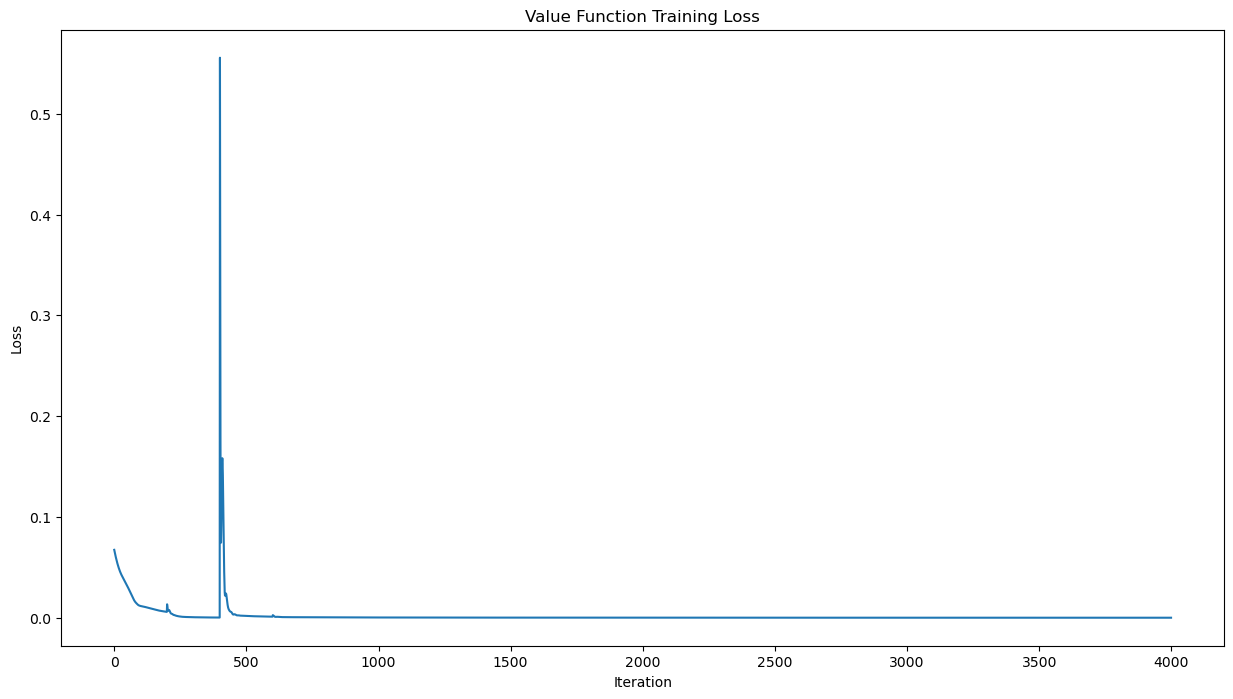

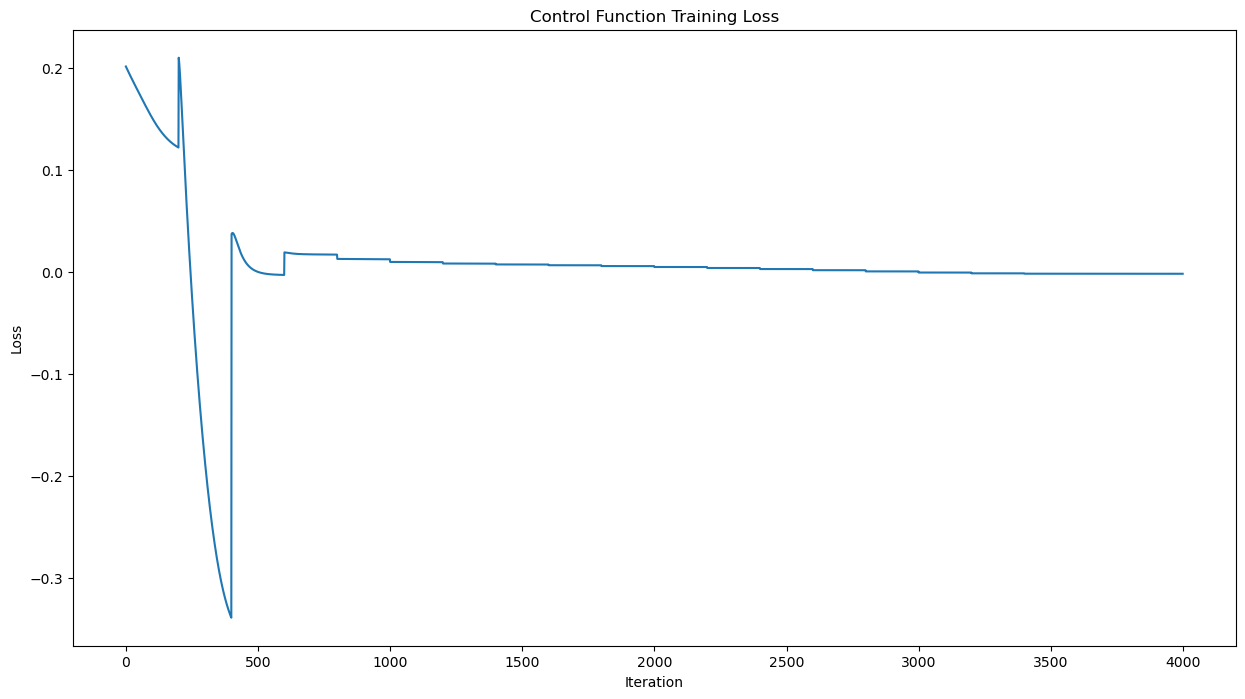

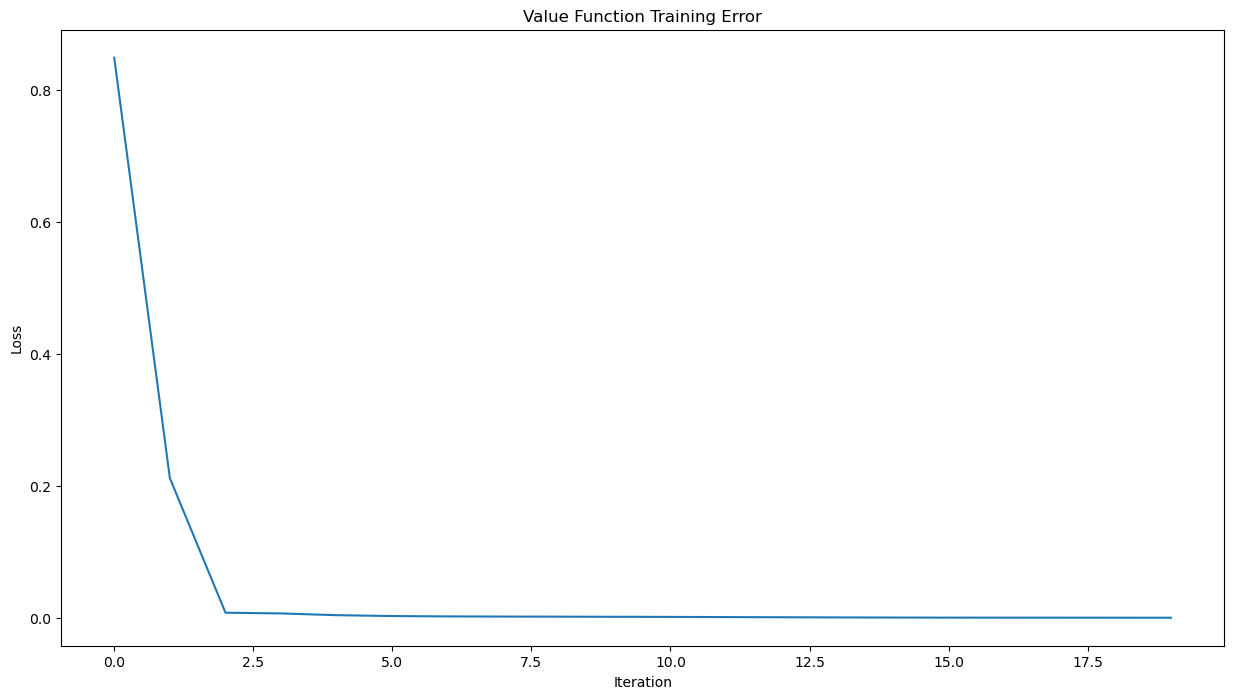

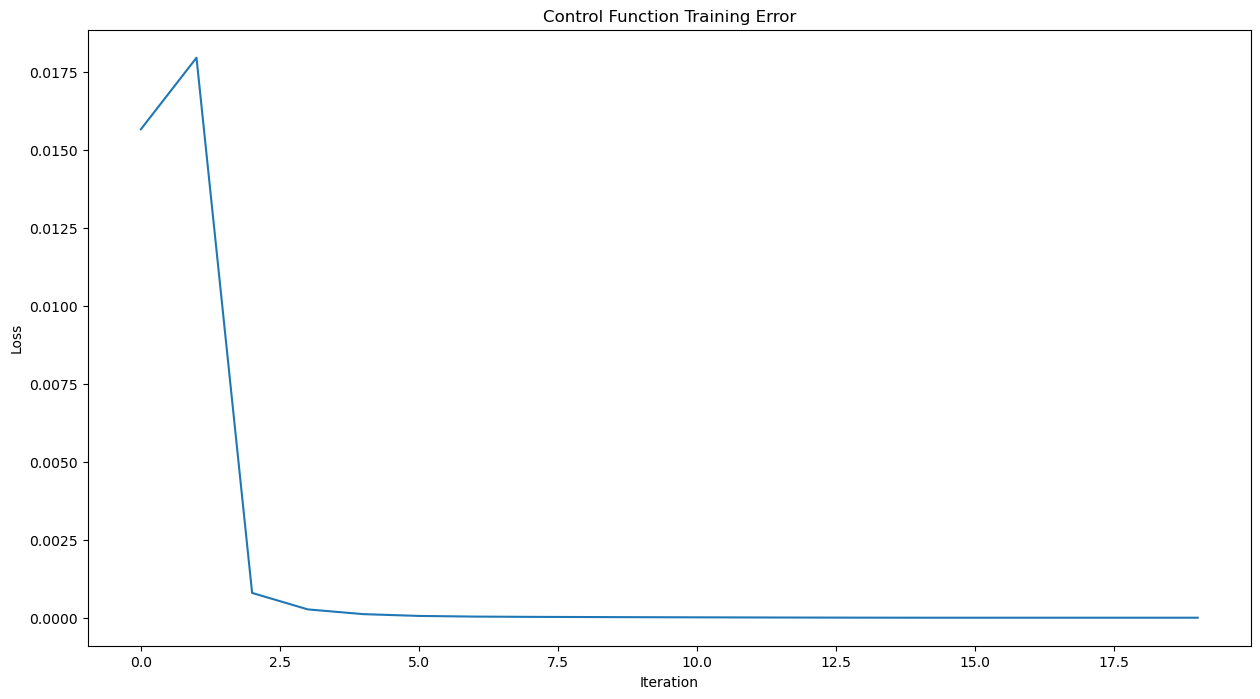

In [9]:
# Neural network
dim_x = 2
dim_S = 100
sizes = [3, 100, 100, 2]  # input_dim=3 (t, x1, x2), output_dim=2
net_act = FFN(sizes).double()
net_val = Net_DGM(dim_x, dim_S).double()

T = 1
batch_size = 500
t_4_batch  = (torch.rand(batch_size, requires_grad=True) * T).double()
x_4_batch= (torch.rand(batch_size,2, requires_grad=True)*2-1).double()
tx_batch = torch.cat((t_4_batch.unsqueeze(1), x_4_batch), dim=1)
v_true = result.value(t_4_batch.detach(),x_4_batch.unsqueeze(1).detach())
a_true = result.control(t_4_batch.detach(),x_4_batch.unsqueeze(1).detach())


optimizer_val = torch.optim.Adam(net_val.parameters(), lr=0.0001)
optimizer_act = torch.optim.Adam(net_act.parameters(), lr=0.0001) 



loss_fn = nn.MSELoss()

max_iterations = 200

policy_iterations = 20
val_losses = []
act_losses = []
error_act_history=[]
error_value_history=[]
# Policy iteration
for policy_iter in range(policy_iterations):
    # i) Update the value function (theta_val)
    for it in range(max_iterations):
        optimizer_val.zero_grad()
        
        a_act =  net_act(tx_batch)
    
        u_of_tx = net_val(t_4_batch.unsqueeze(1), x_4_batch)
        grad_u_x = get_gradient(u_of_tx,x_4_batch)
        grad_u_t = get_gradient(u_of_tx,t_4_batch)
        grad_u_xx = get_hess(grad_u_x, x_4_batch)
    
        trace = torch.matmul(sigma.view(1, 2, 1).double(), sigma.view(1, 1, 2).double()) @ grad_u_xx.double()
        target_functional = torch.zeros_like(u_of_tx)

        pde = grad_u_t+ 0.5 * ((trace[:,0,0]) + (trace[:,1,1])) + (grad_u_x.unsqueeze(1) @ H @ x_4_batch.unsqueeze(2))[:,0,0] + (grad_u_x.unsqueeze(1) @ M @ a_act.unsqueeze(2))[:,0,0] + ((x_4_batch).unsqueeze(1) @ (C @ x_4_batch.unsqueeze(2)))[:,0,0] + (a_act.unsqueeze(1) @ D @ a_act.unsqueeze(2 ))[:,0,0]

        MSE_functional = loss_fn(torch.reshape(pde,(batch_size,1)), target_functional)
    

    # Compute the terminal condition residual       
    
        x_batch_terminal = x_4_batch
        t_batch_terminal =(torch.ones(batch_size) * T).double()
        u_of_Tx = net_val(t_batch_terminal.unsqueeze(1), x_batch_terminal)
        target_terminal = x_batch_terminal.unsqueeze(1) @ R @ x_batch_terminal.unsqueeze(2)
 
        MSE_terminal = loss_fn(u_of_Tx, target_terminal[:,:,0])
    # Compute total loss
        loss = MSE_functional + MSE_terminal
        loss.backward(retain_graph=True)

    # Backpropagation and optimization
        optimizer_val.step()
        
        val_losses.append(loss.item())
    error_value = loss_fn(v_true,u_of_tx)
    error_value_history.append(error_value.item())    
    # ii) Update the control function (theta_act)
    for it in range(max_iterations):
        optimizer_act.zero_grad()
        a_act =  net_act(tx_batch)
        u_of_tx = net_val(t_4_batch.unsqueeze(1), x_4_batch)
        grad_u_x = get_gradient(u_of_tx,x_4_batch)
        grad_u_t = get_gradient(u_of_tx,t_4_batch)
        grad_u_xx = get_hess(grad_u_x, x_4_batch)
        

        Hami = (grad_u_x.unsqueeze(1) @ H @ x_4_batch.unsqueeze(2))[:,0,0] + (grad_u_x.unsqueeze(1) @ M @ a_act.unsqueeze(2))[:,0,0] + (x_4_batch.unsqueeze(1) @ C @ x_4_batch.unsqueeze(2))[:,0,0] + (a_act.unsqueeze(1) @ D @ a_act.unsqueeze(2))[:,0,0]

        Hamiltonian = (torch.mean(Hami,dim=0 ))
    

    # Compute the terminal condition residual       
    
    # Compute total loss
        loss1 = Hamiltonian
        loss1.backward(retain_graph=True)

    # Backpropagation and optimization
    
        optimizer_act.step()
       
        act_losses.append(loss1.item())
    error_act = loss_fn(a_true,a_act)
    error_act_history.append(error_act.item())

plt.figure(figsize=(15, 8))
plt.plot(val_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Value Function Training Loss')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(act_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Control Function Training Loss')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(error_act_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Value Function Training Error')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(error_value_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Control Function Training Error')
plt.show()

**Plots Introduction:**
The training loss of neural networks is often used to assess their learning progress during the training process. In this part, we plotted the training loss of two neural networks, DGM and FNN, to evaluate their learning progress during the iteration of policy iteration.The number of policy iteration is setted to 20, which means that the networks are trained 20 times with different parameter(if not converge). Each graph contains the training error of the neural network for 20 iterations, with each neural network iteration comprising 200 training cycles. 

To further evaluate the accuracy of the networks' approximations of the optimal value and control, we calculated and plotted the errors between their outputs and the true optimal value and optimal control values obtained from Exercise 1.1.

**Results:**
The first two figures demonstrate that both the loss of DGM network and FNN network exhibit decreasing trends during each iteration of policy. The DGM's training losses decrease during each iteration of policy, suggesting that the DGM neural network effectively learn to approximate the value with a given action. There are several protrusions in the plot, which is a normal phenomenon that occurs when a new training of the DGM network begins because the action in the PDE in Exercise 3 changes. The FNN's training losses also decrease during each iteration of policy, suggesting that the FNN neural network effectively learn to approximate the action with a given value. The mutation in the picture is normal as it is a new training of the FNN network with a new given value. The training losses of both FNN and DGM networks converge with the iteration of policy, implying that the networks may have found the optimal value and optimal control.

To determine whether the networks find the true optimal value and optimal control, the error between the output of FNN and the optimal control and the error between the output of DGM and the optimal value are plotted in each policy iteration as the last two figure. The MSEs decrease and approch to 0 as the iteration of policy, indicating that the networks find the optimal value and optimal control.

**Conclusion:**\
In conclusion, the Policy Iteration Algorithm is a viable approach for approximating the value and control functions for the given initial time and space, and it converges to the correct solution as demonstrated by the decreasing errors over policy iterations.

## References<a name="references"></a>

- M. Sabate-Vidales, Deep-PDE-Solvers, Github project,https://github.com/msabvid/Deep-PDE-Solvers, 2021.
- C. Jiang, Deep Galerkin Method, Github project, https://github.com/EurasianEagleOwl/DeepGalerkinMethod, 2022.
- G. dos Reis and D. Sˇiˇska. Stochastic Control and Dynamic Asset Allocation.https://www.maths.ed.ac.uk/∼dsiska/LecNotesSCDAA.pdf. 2021.